In [1]:
import sys
sys.path.insert(0, '..')
from mlconfound.stats import confound_test
from mlconfound.simulate import simulate

import numpy as np
import pandas as pd
import warnings
warnings.simplefilter("always")
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt

from scipy.stats import linregress

In [10]:
#                     true signal     confounder
y, yhat, c = simulate(0.6,       0.3,     # y
                      0,         0.9,     # c
                      0.4,       0.0,  # yhat
                      n=30,                            # simulated sample size
                      random_state=42
                      )

In [23]:
def conditional_permutation_gaussian(nstep, M, X0)


# generate CPT copies of X when the conditional distribution is Gaussian
# i.e. X | Z=Z_i ~ N(mu[i],sig2[i])
def generate_X_CPT_gaussian(nstep,M,X0,mu,sig2):
    log_lik_mat = - np.power(X0,2)[:,None] * (1/2/sig2)[None,:] + X0[:,None] * (mu/sig2)[None,:]
    Pi_mat = generate_X_CPT(nstep,M,log_lik_mat)
    return X0[Pi_mat]

# generate CPT copies of X in general case
# log_lik_mat[i,j] = q(X[i]|Z[j]) where q(x|z) is the conditional density for X|Z
def generate_X_CPT(nstep,M,log_lik_mat,Pi_init=[]):
    n = log_lik_mat.shape[0]
    if len(Pi_init)==0:
        Pi_init = np.arange(n,dtype=int)
    Pi_ = generate_X_CPT_MC(nstep,log_lik_mat,Pi_init)
    Pi_mat = np.zeros((M,n),dtype=int)
    for m in range(M):
        Pi_mat[m] = generate_X_CPT_MC(nstep,log_lik_mat,Pi_)
    return Pi_mat

def generate_X_CPT_MC(nstep,log_lik_mat,Pi):
    n = len(Pi)
    npair = np.floor(n/2).astype(int)
    for istep in range(nstep):
        perm = np.random.choice(n,n,replace=False)
        #print(perm)
        inds_i = perm[0:npair]
        inds_j = perm[npair:(2*npair)]
        # for each k=1,...,npair, decide whether to swap Pi[inds_i[k]] with Pi[inds_j[k]]
        log_odds = log_lik_mat[Pi[inds_i],inds_j] + log_lik_mat[Pi[inds_j],inds_i] \
            - log_lik_mat[Pi[inds_i],inds_i] - log_lik_mat[Pi[inds_j],inds_j]
        swaps = np.random.binomial(1,1/(1+np.exp(-np.maximum(-500,log_odds))))
        Pi[inds_i], Pi[inds_j] = Pi[inds_i] + swaps*(Pi[inds_j]-Pi[inds_i]), Pi[inds_j] - \
            swaps*(Pi[inds_j]-Pi[inds_i])   
    #print(Pi)
    return Pi

In [13]:
np.random.choice(10,10,replace=False)

array([1, 4, 9, 8, 2, 6, 7, 5, 0, 3])

In [16]:
fit = linregress(y,c)
chat = fit.intercept + fit.slope*y
resid = c - chat
resid_std = np.std(resid)
resid_sigma2 = np.repeat( np.power(resid_std, 2), len(y))
fit.rvalue

0.3125001134464917

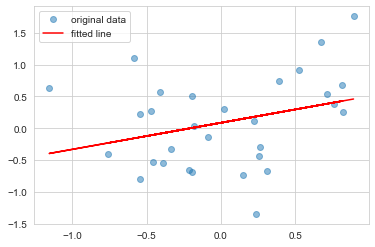

array([0.44771697, 0.44771697, 0.44771697, 0.44771697, 0.44771697,
       0.44771697, 0.44771697, 0.44771697, 0.44771697, 0.44771697,
       0.44771697, 0.44771697, 0.44771697, 0.44771697, 0.44771697,
       0.44771697, 0.44771697, 0.44771697, 0.44771697, 0.44771697,
       0.44771697, 0.44771697, 0.44771697, 0.44771697, 0.44771697,
       0.44771697, 0.44771697, 0.44771697, 0.44771697, 0.44771697])

In [17]:
plt.plot(y, c, 'o', label='original data', alpha=0.5)
plt.plot(y, chat, 'r', label='fitted line')
plt.legend()
plt.show()
resid_sigma2

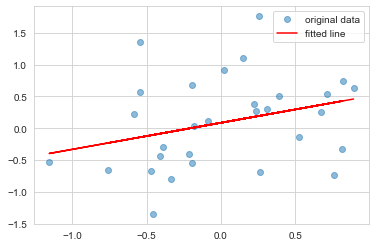

0.28323067054879497

In [57]:
cstars = generate_X_CPT_gaussian(10, 1, c, chat, resid_sigma2)
plt.plot(y, cstars.flatten(), 'o', label='original data', alpha=0.5)
plt.plot(y, chat, 'r', label='fitted line')
plt.legend()
plt.show()
resid_sigma2
np.mean(np.corrcoef(y, cstars)[0,1:])

In [344]:
# c | y=y_i ~ N(c[i],sig2)

chat_sigma2 = np.array( np.power(fit.stderr/np.sqrt(len(c)), 2), len(y))
cstars = generate_X_CPT_gaussian(10, 10, np.random.permutation(c), c, chat_sigma2)
np.mean(np.corrcoef(y, cstars)[0,1:])

IndexError: invalid index to scalar variable.

In [341]:
for cstar in cstars:
    print(np.corrcoef(y, cstar)[0,1])

0.6235306553959012
0.6727177641225096
0.6649582583309656
0.6649582583309656
0.6667116228718885
0.6649582583309656
0.6649582583309656
0.6705071006680026
0.6705071006680026
0.6645009594173814


In [342]:
np.sqrt(np.mean(np.power(y-yhat, 2)))

0.3744822245697951

In [343]:
chat_sigma2 = np.repeat( 0.3894536006472516*np.sqrt(len(y)), len(y))
cstars = generate_X_CPT_gaussian(10, 10, np.random.permutation(c), chat, chat_sigma2)
np.mean(np.corrcoef(y, cstars)[0,1:])

[6 0 2 8 9 4 5 7 3 1]
[6 1 8 5 0 7 9 2 4 3]
[6 8 4 0 9 2 1 3 5 7]
[0 3 7 8 9 6 1 4 5 2]
[6 3 0 5 1 9 8 7 4 2]
[2 7 8 3 4 0 6 5 1 9]
[8 5 0 6 3 4 7 1 2 9]
[5 1 6 9 7 4 0 8 2 3]
[0 3 5 6 7 8 4 1 9 2]
[0 2 4 8 6 3 9 1 5 7]
[4 7 1 0 2 8 9 6 5 3]


0.20867438558494614

In [345]:
np.cov(y,c)

array([[0.41510916, 0.27473102],
       [0.27473102, 0.4112106 ]])

In [425]:
y, yhat, c = simulate(0.6,       0.3,     # y
                      0,         0.9,     # c
                      0.4,       0.0,  # yhat
                      n=100000,                            # simulated sample size
                      random_state=None
                      )
print(np.corrcoef(y, c)[0,1])
ret=[]
for i in range(100):
 ret.append(np.corrcoef(np.random.multivariate_normal(np.mean((y,c), axis=1), np.cov(y, c), 10).transpose())[0,1])
np.mean(ret)

0.4414677516922771


0.3769825037766437

In [375]:
np.mean((y,c), axis=1)

array([-0.11016888,  0.25436707])

In [428]:
X0 = np.array([1,2,3,4,5,6])
mu = np.array([3,3,3,3,3,3])
sig2 = np.array([1,1,1,1,1,1])
- np.power(X0,2)[:,None] * (1/2/sig2)[None,:] + X0[:,None] * (mu/sig2)[None,:]

array([[2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
       [4. , 4. , 4. , 4. , 4. , 4. ],
       [4.5, 4.5, 4.5, 4.5, 4.5, 4.5],
       [4. , 4. , 4. , 4. , 4. , 4. ],
       [2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
       [0. , 0. , 0. , 0. , 0. , 0. ]])